In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Astrometric displacement

Let's define the astrometric effect of a GW on a set of stars; this will be given by the displacement `dN`. We will also construct GW polarization basis tensors to construct arbitrary GWs.

In [59]:
def dN(h, n, q):
    """Displacement induced by gravitational wave, Eq. (20) in
    arXiv:1804.00660
    
    Arguments
    ---------
    h : array_like
        gravitational wave strain tensor (3x3)
    n : array_like
        direction to the source.
    q : array_like
        wave propagation direction.
    """
    n = np.array(n)
    q = np.array(q)
    h = np.array(h).reshape(3,3)
    
    term1 = (n - q) / (1 - np.dot(q, n))

    term2 = np.einsum('jk,j,k', h, n, n)
    
    term3 = np.einsum('ij,j', h, n)

    result = 0.5 * (term1 * term2 - term3)
    
    return result

# GW polarization tensors
# WARNING: these expressions assume GW propagates in the z direction, so we must
# have q = (0, 0, 1)
ep = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
ec = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])

# GW waveform
def gw(ap, ac, phi):
    """Gravitational wave strain tensor (circularly polarized wave).
    
    Arguments
    ---------
    ap : float
        amplitude of the plus polarization
    ac : float
        amplitude of the cross polarization
    phi : float
        phase of the wave
    """
    return ap * ep * np.cos(phi) + ac * ec * np.sin(phi)

## Night sky

We will apply the effect of our GW to a field of simulated stars on the night sky.

In [60]:
# create a field of stars to observe
rng = np.random.default_rng(150914)
n_stars = 1000
stars = rng.normal(0, 1, (n_stars, 3))
stars /= np.linalg.norm(stars, axis=1)[:, np.newaxis]

# for visualization, we will only want stars in a single hemisphere
# so force all stars to have positive z component
hemisphericstars = stars.copy()
hemisphericstars[:, 2] = np.abs(hemisphericstars[:, 2])

Let's look at the stars we have created as they are distributed over the celestial sphere:

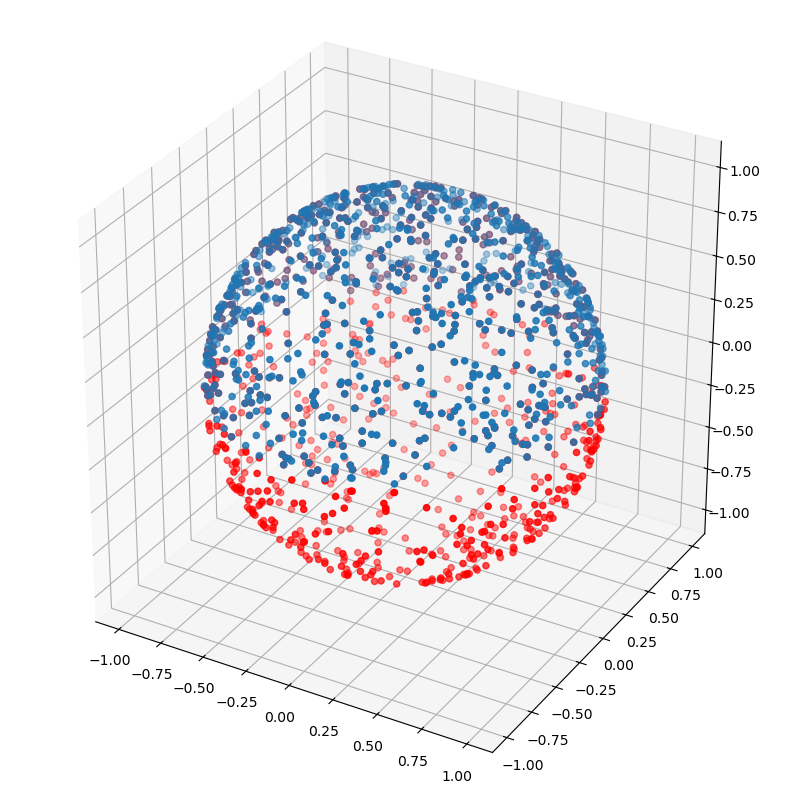

In [61]:
# 3D scatter plot of the stars
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stars[:, 0], stars[:, 1], stars[:, 2], c='r')
ax.scatter(hemisphericstars[:, 0], hemisphericstars[:, 1], hemisphericstars[:, 2])
# make square aspect ratio
ax.set_box_aspect([1,1,1])

Since we will imagine staring up at the sky, we will project our stars onto the field of view (a plane):

In [62]:
# finally, we will want to look at the projection of the hemisphere
flatstars = hemisphericstars[:, :2]

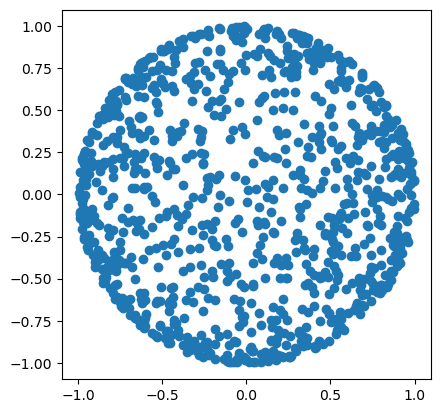

In [63]:
fig, ax = plt.subplots()
ax.scatter(flatstars[:, 0], flatstars[:, 1])
ax.set_aspect('equal')

## Displacement

Now we apply the GW to our set of simulated stars.

In [65]:
def dstar(n):
    """ Displacement of a star due to a gravitational wave
    propagating in the z direction.
    """
    return dN(gw(0.1, 0, 0), n, [0, 0, 1])

# get set of displacements for all stars
d = np.array(list(map(dstar, hemisphericstars)))

# update the star locations
newstars = hemisphericstars + d
newstars /= np.linalg.norm(newstars, axis=1)[:, np.newaxis]

newflatstars = newstars[:, :2]

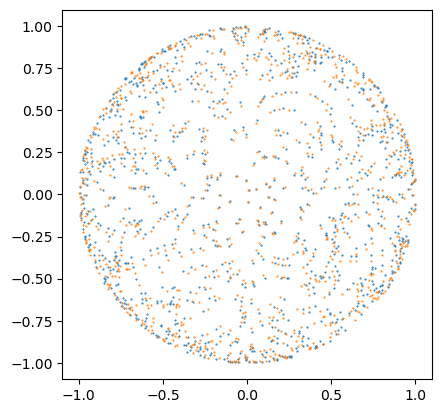

In [66]:
fig, ax = plt.subplots()
ax.scatter(flatstars[:, 0], flatstars[:, 1], marker='.', s=1)
ax.scatter(newflatstars[:, 0], newflatstars[:, 1], marker='.', s=1)
ax.set_aspect('equal')

In [ ]:
# def plot_stars(phi, ap=0.1, ac=0, ax=None):
#     def dstar_loc(n):
#         return dN(gw(ap, ac, phi), hemisphericstars, [0, 0, 1])
#     d = np.array(list(map(dstar_loc, hemisphericstars)))
#     newstars = hemisphericstars + d
#     newstars /= np.linalg.norm(newstars, axis=1)[:, np.newaxis]
#     newflatstars = newstars[:, :2]
    
#     if ax is None:
#         fig, ax = plt.subplots()
#         ax.scatter(flatstars[:, 0], flatstars[:, 1], marker='.', s=1)
#     ax.scatter(newflatstars[:, 0], newflatstars[:, 1], marker='.', s=1)

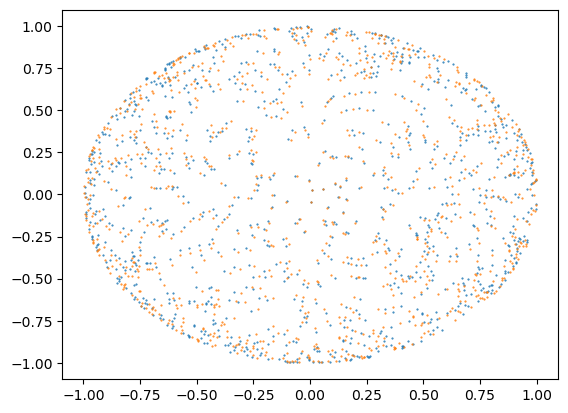

In [69]:
# animate the above plot to make a GIF
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.scatter(flatstars[:, 0], flatstars[:, 1], marker='.', s=1)
sc = ax.scatter([], [], marker='.', s=1)

def animate(phi):
    d = np.array(list(map(dstar, hemisphericstars)))
    newstars = hemisphericstars + d
    newstars /= np.linalg.norm(newstars, axis=1)[:, np.newaxis]
    newflatstars = newstars[:, :2]
    
    sc.set_offsets(newflatstars)
    return sc,

ani = FuncAnimation(fig, animate, frames=np.linspace(0, 2*np.pi, 100), blit=True)
HTML(ani.to_jshtml())